# Modeling

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile, SelectFromModel, f_regression, RFE, RFECV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pickle
import csv

np.random.seed(42) #everytime a random number is generated, it will advance the seed by one every time...

**The following modeling reflect the following changes in my dataset from my first attempt: the filling in null values of masonry veneer type/area with 'None' and 0, respectively and excluding overall_qual column and overall_cond when dummying entire dataset and adding them back in separately:**

In [3]:
X_train_threshold = pd.read_csv('../datasets/X_train_threshold_2_sc.csv', header=None)
X_test_threshold = pd.read_csv('../datasets/X_test_threshold_2_sc.csv', header=None)
y_train = pd.read_csv('../datasets/y_train_2.csv', header=None)
y_test = pd.read_csv('../datasets/y_test_2.csv', header=None)

In [4]:
X_train_threshold.shape

(1537, 151)

In [5]:
X_test_threshold.shape

(513, 151)

## Naive Model

In [6]:
np.mean(y_train)

0    181875.163956
dtype: float64

## Linear Regression

In [10]:
lr = LinearRegression()

In [14]:
lr.fit(X_train_threshold, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [8]:
lr.score(X_train_threshold, y_train)

0.8963160248500164

In [9]:
lr.score(X_test_threshold, y_test)

0.8945684102422927

Assumptions: By fitting a multi-linear regression model, we assume that the features follow an approximately linear relationship with the target variable; that the errors following an approximately normal distribution with mean of 0 and a standard deviation of sigma; that errors are not correlated with each other; that the features are not correlated with one another.

As the model performed slightly better on the training dataset compared to the test, the model may be overfitting the data.

### Import column list to align with values for inference

In [10]:
with open('../assets/columns.pkl', 'rb') as f:
    columns = pickle.load(f)

In [11]:
len(columns)

151

In [12]:
columns;

### Align columns with Beta coefficients

In [13]:
betas_lr = pd.DataFrame(lr.coef_, columns=columns).T ##should we sort?

In [14]:
betas_lr.head()

,0
ms_subclass,598.263038
lot_area,2180.862926
year_built,7588.383668
year_remod/add,828.742549
bsmtfin_sf_1,134783.030697


### Rename the column and create absolute values column for sorting

In [15]:
betas_lr.columns = ['coefficients']

In [16]:
betas_lr['abs_c'] = betas_lr['coefficients'].abs()

### Investigate Beta_0 or the intercept

In [17]:
beta_lr_0 = lr.intercept_[0]

In [18]:
coefficients_lr = betas_lr.sort_values('abs_c', ascending=False)['coefficients'].head(10)

In [19]:
labels_lr = coefficients_lr.index

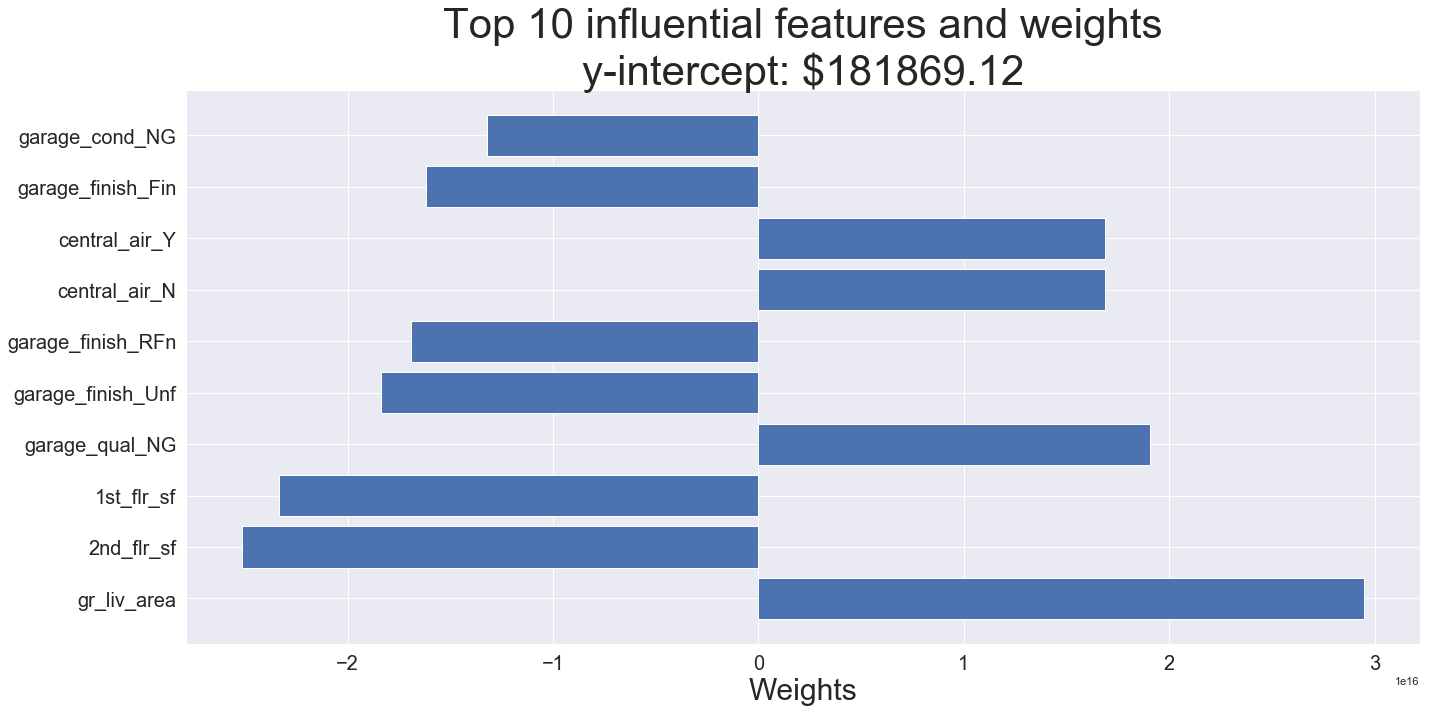

In [20]:
plt.figure(figsize=(20,10))
plt.barh(labels_lr, coefficients_lr)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=30)
plt.title(f'Top 10 influential features and weights\ny-intercept: ${beta_lr_0:0.02f}', fontsize=42)
plt.tight_layout()

Intercept interpretation: Without any features, the saleprice of a home in Ames, Iowa is roughly more than $180,000. Many of the beta coefficients or weights do not pass sanity check. For example, that with an increase in gr_liv_area by a unit of standard deviation (above the mean), the sale price of a home decreases by 2*10e16. Potential issue is due to collinearity. Other models such as Ridge and Lasso will be explored.

### Ridge

In [21]:
ridge = RidgeCV()

In [22]:
ridge.fit(X_train_threshold, y_train)
ridge.score(X_train_threshold, y_train)

0.8959633138612156

In [23]:
ridge.fit(X_test_threshold, y_test)
ridge.score(X_test_threshold, y_test)

0.9532777595382692

In [24]:
betas_rd = pd.DataFrame(ridge.coef_, columns=columns).T

In [25]:
betas_rd.head()

,0
ms_subclass,-2.045304
lot_area,3540.981104
year_built,7313.655064
year_remod/add,2673.125710
bsmtfin_sf_1,7645.930787


Feature betas are reduced (i.e. lot_area reduced from 2968 to 1337)

### Rename the column and create absolute values column for sorting

In [26]:
betas_rd.columns = ['coefficients']

In [27]:
betas_rd['abs_c'] = betas_rd['coefficients'].abs()

### Investigate Beta_0 or the intercept

In [28]:
beta_rd_0 = ridge.intercept_[0]

In [29]:
coefficients_rd = betas_rd.sort_values('abs_c', ascending=False)['coefficients'].head(15)

In [30]:
labels_rd = coefficients_rd.index

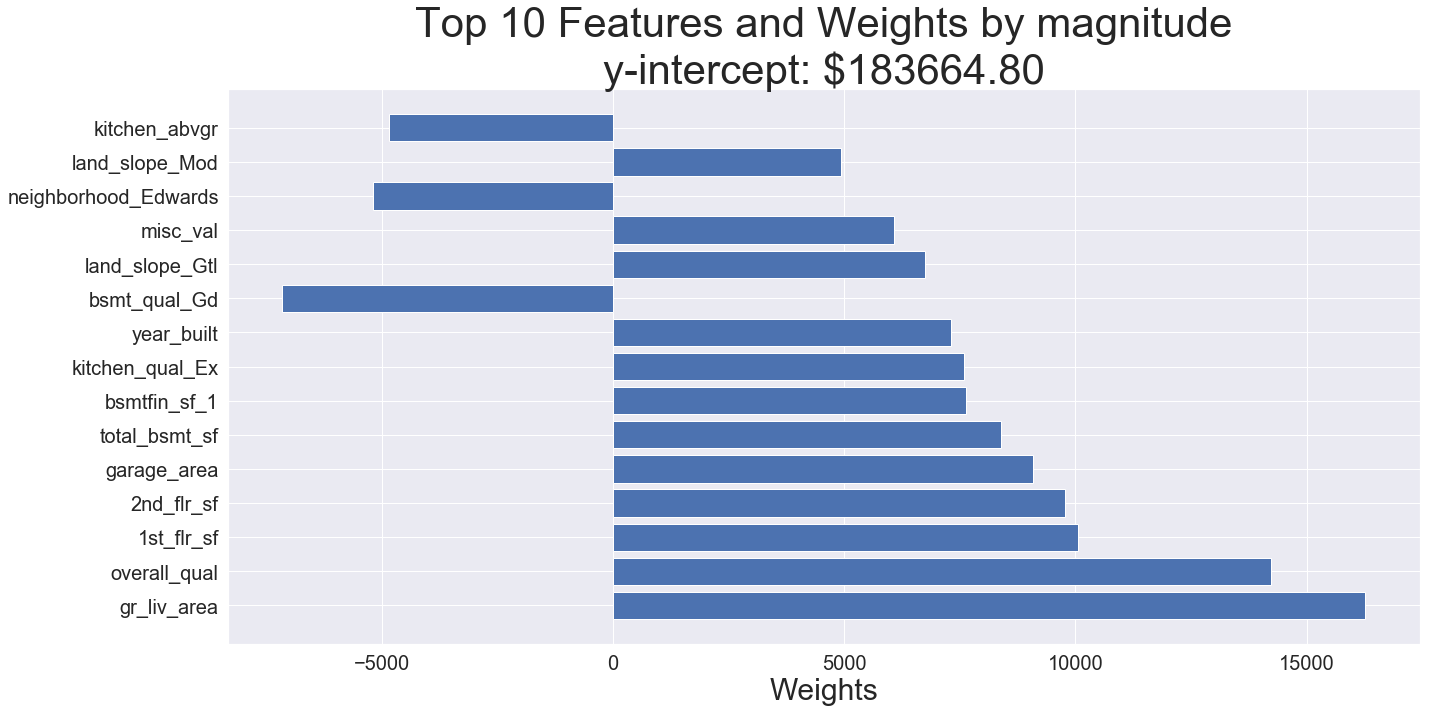

In [31]:
plt.figure(figsize=(20,10))
plt.barh(labels_rd, coefficients_rd)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=30)
plt.title(f'Top 10 Features and Weights by magnitude\ny-intercept: ${beta_rd_0:0.02f}', fontsize=42)
plt.tight_layout()

According to the ridge model, increasing the gr_liv_area by a unit of standard deviation will increase the sale price of the home by more than 15,000 USD.

### Lasso

In [32]:
lasso = LassoCV()

In [33]:
lasso.fit(X_train_threshold, y_train)
lasso.score(X_train_threshold, y_train)

/Users/mintaekhong/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8936435375314816

In [34]:
lasso.fit(X_test_threshold, y_test)
lasso.score(X_test_threshold, y_test)

/Users/mintaekhong/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9440443293505558

In [35]:
lasso.coef_;

In [36]:
len(lasso.coef_)

151

In [37]:
betas_ss = pd.DataFrame(lasso.coef_, index = columns)

In [38]:
betas_ss.head()

,0
ms_subclass,-2246.033634
lot_area,2690.541692
year_built,6014.841787
year_remod/add,2009.663162
bsmtfin_sf_1,6972.651656


In [39]:
betas_ss.sort_values(by=0);

In [40]:
betas_ss_final = betas_ss[betas_ss[0] != 0]

In [41]:
betas_ss_final.shape

(77, 1)

### Rename the column and create absolute values column for sorting

In [42]:
betas_ss.columns = ['coefficients']

In [43]:
betas_ss['abs_c'] = betas_ss['coefficients'].abs()

### Investigate Beta_0 or the intercept

In [44]:
beta_ss_0 = ridge.intercept_[0]

In [45]:
coefficients_ss = betas_ss.sort_values('abs_c', ascending = False)['coefficients'].head(10)

In [46]:
labels_ss = coefficients_ss.index

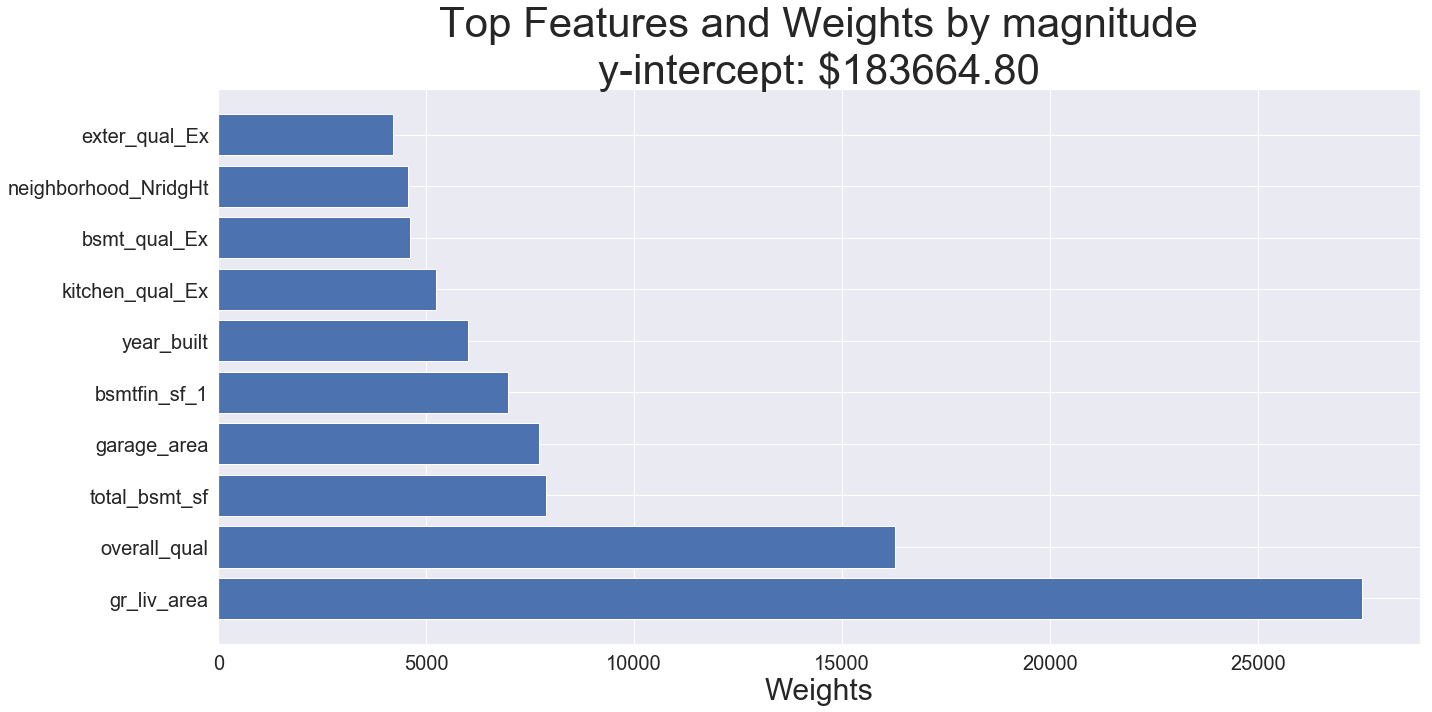

In [47]:
plt.figure(figsize=(20,10))
plt.barh(labels_ss, coefficients_ss)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=30)
plt.title(f'Top Features and Weights by magnitude\ny-intercept: ${beta_ss_0:0.02f}', fontsize=42)
plt.tight_layout()

A step increase from kitchen_qual_Gd to kitchen_qual_Ex will help the sale price of the home increase by 5,200 USD; currently cannot make the inference that the saleprice of the house goes up by ~$5000 in each incremental step (i.e. from poor to fair; fair to typical, typical to good, and good to excellent). But you can interpret it that the step from Gd to Ex had the highest impact compared to for example from TA to Gd. Possible to make the conclusion that if an investor buys a home with good kitchen quality, take the time and resources to make it excellent. The same can be interpreted for basement quality as well as exterior quality.

In [48]:
def md_coef_table(labels, weights):
    print('| feature | weight |\n| --- | --- |')
    for i in range(len(labels)):
        print(f'| {labels_ss[i]} | {coefficients_ss[i]:.2e} |')

In [49]:
md_coef_table(labels_ss, coefficients_ss)

| feature | weight |
| --- | --- |
| gr_liv_area | 2.75e+04 |
| overall_qual | 1.63e+04 |
| total_bsmt_sf | 7.89e+03 |
| garage_area | 7.72e+03 |
| bsmtfin_sf_1 | 6.97e+03 |
| year_built | 6.01e+03 |
| kitchen_qual_Ex | 5.23e+03 |
| bsmt_qual_Ex | 4.61e+03 |
| neighborhood_NridgHt | 4.56e+03 |
| exter_qual_Ex | 4.20e+03 |


| feature | weight |
| --- | --- |
| gr_liv_area | 2.75e+04 |
| overall_qual | 1.63e+04 |
| total_bsmt_sf | 7.89e+03 |
| garage_area | 7.72e+03 |
| bsmtfin_sf_1 | 6.97e+03 |
| year_built | 6.01e+03 |
| kitchen_qual_Ex | 5.23e+03 |
| bsmt_qual_Ex | 4.61e+03 |
| neighborhood_NridgHt | 4.56e+03 |
| exter_qual_Ex | 4.20e+03 |
| overall_cond | 3.84e+03 |
| bsmt_exposure_Gd | 3.76e+03 |
| functional_Typ | 3.58e+03 |
| ms_zoning_RM | -3.35e+03 |
| neighborhood_Edwards | -2.88e+03 |

In [50]:
from sklearn.metrics import mean_squared_error

In [51]:
mean_squared_error(y_test, lr.predict(X_test_threshold)) ** 0.5

25798.241672298896

In [52]:
mean_squared_error(y_test, ridge.predict(X_test_threshold)) ** 0.5 ##on my test/train split... a

17173.806264820287

In [53]:
mean_squared_error(y_test, lasso.predict(X_test_threshold)) ** 0.5

18794.327133600913

Having investigated the three models of linear regression, ridge and lasso, I will use my lasso model as my final production model. Despite the higher RMSE score on lasso versus ridge for y_test, I am able to interpret the coefficients in a more straightfoward manner.

In [54]:
pred = lasso.predict(X_test_threshold)

In [55]:
r2_score(y_test, pred)

0.9440443293505558

The above R^2 score can be interpreted as my lasso model explains more than 90% of my variation in saleprice.

### Versus naive model

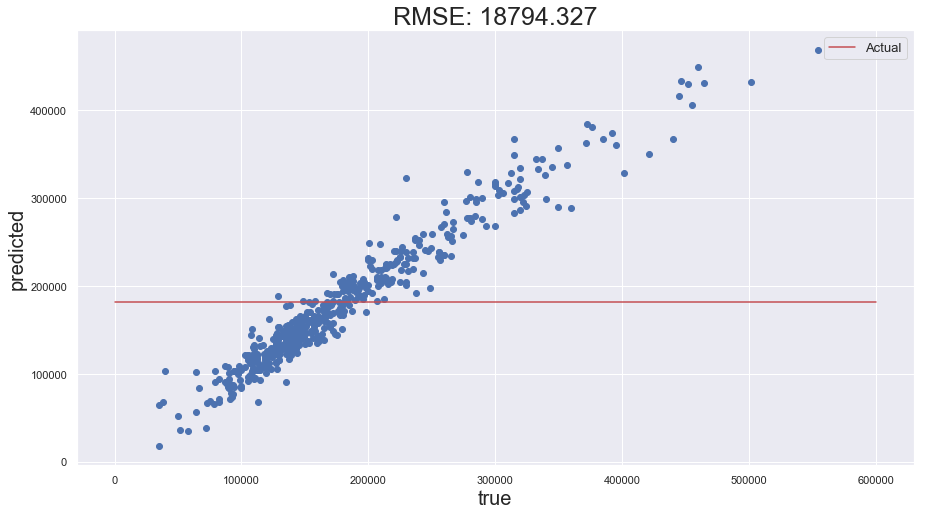

In [56]:
plt.figure(figsize=(15,8))
plt.title(f'RMSE: {mean_squared_error(y_test, pred) ** 0.5:.3f}', fontsize = 25)
plt.scatter(y_test, pred)
plt.ylabel('predicted', fontsize = 20)
plt.xlabel('true', fontsize = 20)
plt.plot([0, 600000], [np.mean(y_train), np.mean(y_train)], color='r')
plt.legend(['Actual'], fontsize = 13)

Against my naive model, which is simly the average of sale prices, my model accounts for features much more closely and hence predicts sale price of homes more accurately than the naive model.

### Versus perfect model

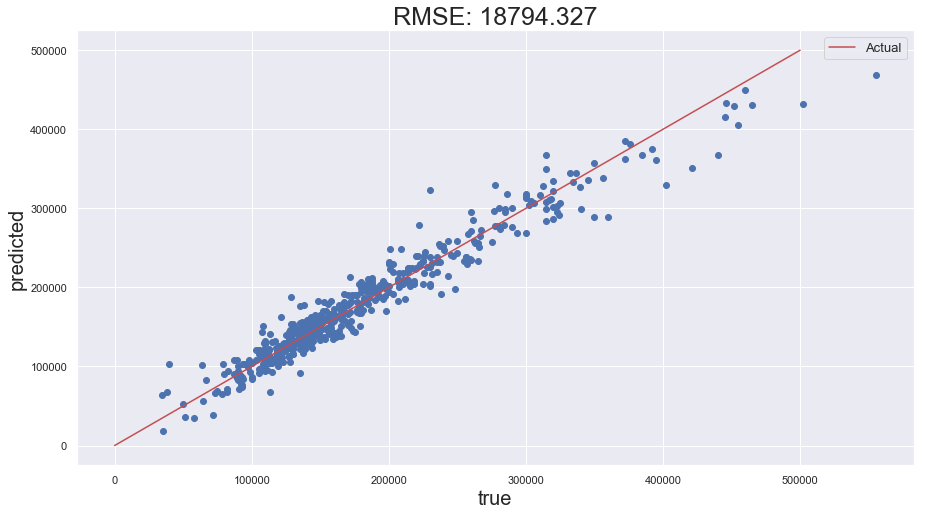

In [57]:
plt.figure(figsize=(15,8))
plt.title(f'RMSE: {mean_squared_error(y_test, pred) ** 0.5:.3f}', fontsize = 25)
plt.scatter(y_test, pred)
plt.ylabel('predicted', fontsize = 20)
plt.xlabel('true', fontsize = 20)
plt.plot([0,500000], [0,500000], color='r')
plt.legend(['Actual'], fontsize = 13)

The above plot shows the relationship between my predictions(x) and true sale prices; the red-line displays a perfectly linear relationship; from my above R^2 score of 0.93, it makes sense that my scatterplots do not lie directly on the red line. The distance between the blue points and red line represent the errors/residuals of the predictions from my lasso model and actual saleprices. My model predicts well for homes until 300,000, but when homes reach the above 300,000 my model tends to under-predict.

## Pickle the model to use later to make predictions

In [58]:
with open('../assets/lasso.pkl', 'wb+') as f:
    pickle.dump(lasso, f)

# Presentation Plots

![saleprice_by_kitchen_qual](./images/saleprice_by_kitchen_qual.png) An individual should first invest in the kitchen of the home as kitchens deemed excellent increase sale price by 5,200. The investor can explore installing new countertops, new appliances and cabinets. It is evident that in this boxplot comparing kitchen quality to sale price that as quality increase, so does sale price.

![saleprice_by_bsmt_qual](./images/saleprice_by_bsmt_qual.png)
After investing in the kitchen, the basement requires attention next. Basements qualified as excellent increase sale price by 4,600. The investor can explore finishing the basement (if any any part of basement is unifinished), and improving air quality. It is evident that in this boxplot comparing basement quality to sale price that as quality increase, so does sale price.


![saleprice_by_exter_qual](./images/saleprice_by_exter_qual.png)
Finally, the investor should spend remaining resources on the exterior quality of the home such as installing motion sensitive lights which is one of the most wanted outdoor features according to National Association of Home Builders (NAHB). It is evident that in this boxplot comparing exterior quality to sale price that as quality increase, so does sale price.



